todo
1. go through all variable names
2. ask which types of groups should "be in focus". Do disabled people count?
3. more advaned duplicate dropping?
4. balancing the dataset needed?
5. dedicated train test split?
6. data augmentation only on train?
7. remove duplicates a second time
8. train test split after tokenization?
9. explain (comment on) that you've got 2 models in the questionnair

# Hate speech Detection

In [209]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, f1_score

from keras.callbacks import EarlyStopping
from keras.layers import LSTM, Dense, Embedding
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

### Data Exploration

In [210]:
data = pd.read_csv('Hate Speech Data.csv')
data

,case_id,test_case,label_gold,target_ident
0,1,I hate women.,hateful,women
1,2,I hate trans people.,hateful,trans people
2,3,I hate gay people.,hateful,gay people
3,4,I hate black people.,hateful,black people
4,5,I hate disabled people.,hateful,disabled people
...,...,...,...,...
3896,3897,Gay people are all complete 4ssholes.,hateful,gay people
3897,3898,Black people are all complete 4ssholes.,hateful,black people
3898,3899,Disabled people are all complete 4ssholes.,hateful,disabled people
3899,3900,Muslims are all complete 4ssholes.,hateful,Muslims


Looks like the dataset contains some missing values in the target_ident column, which we'll have to deal with later

In [211]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3901 entries, 0 to 3900
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   case_id       3901 non-null   int64 
 1   test_case     3901 non-null   object
 2   label_gold    3901 non-null   object
 3   target_ident  3606 non-null   object
dtypes: int64(1), object(3)
memory usage: 122.0+ KB


In [212]:
data[data.isna().any(axis=1)].head()

,case_id,test_case,label_gold,target_ident
1271,1272,"Fucking hell, what a day.",non-hateful,NaN
1272,1273,That's a great fucking idea.,non-hateful,NaN
1273,1274,No fucking way.,non-hateful,NaN
1274,1275,I'm so fucking excited.,non-hateful,NaN
1275,1276,Are you fucking kidding me?,non-hateful,NaN


No duplicate texts found

In [213]:
print(f'''duplicate texts: {data['test_case'].duplicated().any()}''')

duplicate texts: False


While the target groups are essentially balanced, the same cannot be said for the hate/non-hate categories

In [214]:
# Using display() to display both at the same time without weird notebook formatting.
# (Won't comment on any future use of display() again. Same as for any other obvious piece of code)
display(
    pd.DataFrame(data['label_gold'].value_counts()),
    pd.DataFrame(data['target_ident'].value_counts())
)

,count
label_gold,
hateful,2659
non-hateful,1242


,count
target_ident,
gay people,577
women,535
disabled people,510
Muslims,510
black people,504
trans people,485
immigrants,485


No unusually short/long texts

In [215]:
longest_text_length = data['test_case'].str.len().max()
shortest_text_length = data['test_case'].str.len().min()

longest_text_index = data['test_case'].str.len().idxmax()
shortest_text_index = data['test_case'].str.len().idxmin()

print(
    f'''Shortest: {longest_text_length} chars, "{data['test_case'][longest_text_index]}"\n'''
    f'''Longest: {shortest_text_length} chars, "{data['test_case'][shortest_text_index]}"'''
)

Shortest: 104 chars, "When will it finally be clear to people that it's in a disabled person's nature to be an annoying prick?"
Longest: 11 chars, "Ihate women"


### Data cleaning

Drop irrelevant columns and rename the rest to something more appropriate

In [216]:
data = data.drop('case_id', axis=1)
data = data.rename(columns=
{
    'test_case': 'text',
    'label_gold': 'label',
    'target_ident': 'target',
})

data.head()

,text,label,target
0,I hate women.,hateful,women
1,I hate trans people.,hateful,trans people
2,I hate gay people.,hateful,gay people
3,I hate black people.,hateful,black people
4,I hate disabled people.,hateful,disabled people


It appears as though non of the missing targets have any relevant hate speech associated with them. This can easily be varified by manually looking at the dataset (given its tiny size), But alas, given my horrendous dyslexia i decided to programmatically varify it as a sanity check

In [217]:
# Easier than grabbing them from the "target" column and removing the trailing "people"
target_search_words = [
    'gay',
    'women',
    'disabled',
    'Muslims',
    'black',
    'trans',
    'immigrants'
]

target_nans = data[data['target'].isna()]

'''
After having spent 9 hours (no kidding) trying to make this piece of *** work with pandas queries,
i settled for the caveman solution of two loops. Being bad at programming is frankly an understatement at this point.
Might as well dig my own grave. And even that'd be done using for loops...
'''
for _, row in target_nans.iterrows():
    for target_search_word in target_search_words:
        # Split by words and search each one
        if target_search_word in row['text'].split(' '):
            print(f'''found target word in: "{row['text']}" row''')

I'm now confident in dropping all rows with target NaN values

In [218]:
data = data.dropna()

Balancing the dataset

In [219]:
# Get the number of hate/non-hate rows
hateful_count = data['label'].value_counts()['hateful']
non_hateful_count = data['label'].value_counts()['non-hateful']

hateful_to_drop_count = hateful_count - non_hateful_count

# Randomly sample the rows and drop
rows_indexes_to_remove = data[data['label'] == 'hateful'].sample(n=hateful_to_drop_count).index
data = data.drop(rows_indexes_to_remove)

display(
    pd.DataFrame(data['label'].value_counts()),
    pd.DataFrame(data['target'].value_counts())
)

,count
label,
hateful,947
non-hateful,947


,count
target,
gay people,325
women,289
black people,269
Muslims,266
disabled people,266
immigrants,245
trans people,234


### Data Preprocessing

Shuffle the dataset

In [220]:
data = data.sample(frac=1)

# Reset index after having both balanced and shuffled
data = data.reset_index(drop=True)
data.head()

,text,label,target
0,We should look up to these immigrants.,non-hateful,immigrants
1,Immigrants are beautiful.,non-hateful,immigrants
2,That moment was really pivotal for queer cultu...,non-hateful,gay people
3,"As I see it, we should get rid of women once a...",hateful,women
4,Today is national coming out day. Here's to al...,non-hateful,gay people


Tokenize and pad the texts

In [221]:
max_words_to_use = 1000

# Use 1k words as that's plenty for our use case
tokenizer = Tokenizer(num_words=max_words_to_use)
tokenizer.fit_on_texts(data['text'])
tokenized_texts = tokenizer.texts_to_sequences(data['text'])

# printing using loop for easier viewing
for i in range(5):
    print(f'Sequence {i}: {tokenized_texts[i]}')

Sequence 0: [28, 25, 216, 158, 3, 42, 24]
Sequence 1: [24, 2, 310]
Sequence 2: [12, 262, 114, 76, 730, 18, 115, 632]
Sequence 3: [83, 6, 84, 41, 28, 25, 54, 210, 20, 26, 230, 36, 18, 8]
Sequence 4: [131, 19, 731, 732, 132, 493, 733, 3, 8, 35, 734, 189]


Given the stochasticity of "sample()" when balancing our dataset, we now need to figure out the longest sequence of tokenized words before we can perform padding.
###### _Well... we don't technically need to know this... but i'd certainly never forgive myself knowing i had left unnecessary zeros in the padding process._

In [222]:
max_sequence_length = len(max(tokenized_texts, key=len))
print(f'longest sequence: {max_sequence_length}')

longest sequence: 20


In [223]:
# Pad the sequences to make them of uniform length
tokenized_padded_texts = pad_sequences(tokenized_texts, maxlen=max_sequence_length)

for i in range(5):
    print(f'seq {i}: {tokenized_padded_texts[i].tolist()}')

seq 0: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 28, 25, 216, 158, 3, 42, 24]
seq 1: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 24, 2, 310]
seq 2: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 262, 114, 76, 730, 18, 115, 632]
seq 3: [0, 0, 0, 0, 0, 0, 83, 6, 84, 41, 28, 25, 54, 210, 20, 26, 230, 36, 18, 8]
seq 4: [0, 0, 0, 0, 0, 0, 0, 0, 131, 19, 731, 732, 132, 493, 733, 3, 8, 35, 734, 189]


One-hot encode the labels

In [224]:
label_binarizer = LabelBinarizer()
onehot_encoded_labels = label_binarizer.fit_transform(data['label'])
onehot_encoded_targets = label_binarizer.fit_transform(data['target'])

print(f'labels: {onehot_encoded_labels.tolist()[:5]}')

for i in range(5):
    print(f'Target {i}: {onehot_encoded_targets[i].tolist()}')

labels: [[1], [1], [1], [0], [1]]
Target 0: [0, 0, 0, 0, 1, 0, 0]
Target 1: [0, 0, 0, 0, 1, 0, 0]
Target 2: [0, 0, 0, 1, 0, 0, 0]
Target 3: [0, 0, 0, 0, 0, 0, 1]
Target 4: [0, 0, 0, 1, 0, 0, 0]


Train/test split

In [225]:
train_texts, test_texts, train_labels, test_labels, train_targets, test_targets = train_test_split(
    tokenized_padded_texts,
    onehot_encoded_labels,
    onehot_encoded_targets,
    test_size=0.2
)

print(
    f'train_texts shape: {np.shape(train_texts)}\n'
    f'train_labels shape: {np.shape(train_labels)}\n'
    f'train_targets shape: {np.shape(train_targets)}\n'
    f'test_texts shape: {np.shape(test_texts)}\n'
    f'test_labels shape: {np.shape(test_labels)}\n'
    f'test_targets shape: {np.shape(test_targets)}'
)

train_texts shape: (1515, 20)
train_labels shape: (1515, 1)
train_targets shape: (1515, 7)
test_texts shape: (379, 20)
test_labels shape: (379, 1)
test_targets shape: (379, 7)


# Model building, training and optimizing
###### At last!

In [226]:
# All models and histories will be stored here
models = {}

# Easiest and most human readable way of doing it while training two models with different parameters
# without having to use a bunch of ugly if-statements and duplicate code. Trust me, i tried the other methods.
model_parameters = zip(
    ['Hate Detection', 'Target Detection'],
    [train_labels, train_targets],
    ['sigmoid', 'softmax'],
    ['binary_crossentropy', 'categorical_crossentropy']
)

for model_name, labels, output_activation_function, loss_function in model_parameters:
    model = Sequential([
        Embedding(
            input_dim=max_words_to_use,
            input_length=max_sequence_length,
            output_dim=32
        ),
        LSTM(units=32, activation='tanh'),
        
        # The number of neurons at the output depends on the number of classes.
        # We get the number of classes by taking the shape of the label arrays as they're one-hot encoded
        Dense(labels.shape[1], activation=output_activation_function)
    ])

    model.compile(optimizer='adam', loss=loss_function, metrics=['accuracy'])

    # Using a patience and start_from_epoch of 10 as the model is still all over the place before that
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, start_from_epoch=10)
    history = model.fit(train_texts, labels, epochs=100, validation_split=0.2, callbacks=[early_stopping], verbose=1)
    models[model_name] = {'model': model, 'history': history}

Epoch 1/100


38/38 [==============================] - 6s 39ms/step - loss: 0.6842 - accuracy: 0.6056 - val_loss: 0.6576 - val_accuracy: 0.6667
Epoch 2/100
38/38 [==============================] - 1s 18ms/step - loss: 0.5754 - accuracy: 0.7483 - val_loss: 0.5053 - val_accuracy: 0.7789
Epoch 3/100
38/38 [==============================] - 1s 18ms/step - loss: 0.3748 - accuracy: 0.8589 - val_loss: 0.3510 - val_accuracy: 0.8284
Epoch 4/100
38/38 [==============================] - 1s 20ms/step - loss: 0.2290 - accuracy: 0.9101 - val_loss: 0.2254 - val_accuracy: 0.9307
Epoch 5/100
38/38 [==============================] - 1s 18ms/step - loss: 0.1325 - accuracy: 0.9538 - val_loss: 0.1562 - val_accuracy: 0.9043
Epoch 6/100
38/38 [==============================] - 1s 21ms/step - loss: 0.0837 - accuracy: 0.9785 - val_loss: 0.0984 - val_accuracy: 0.9736
Epoch 7/100
38/38 [==============================] - 1s 20ms/step - loss: 0.0475 - accuracy: 0.9893 - val_loss: 0.1038 - val_accuracy: 0.9769
Epoch 8/100
38/38 

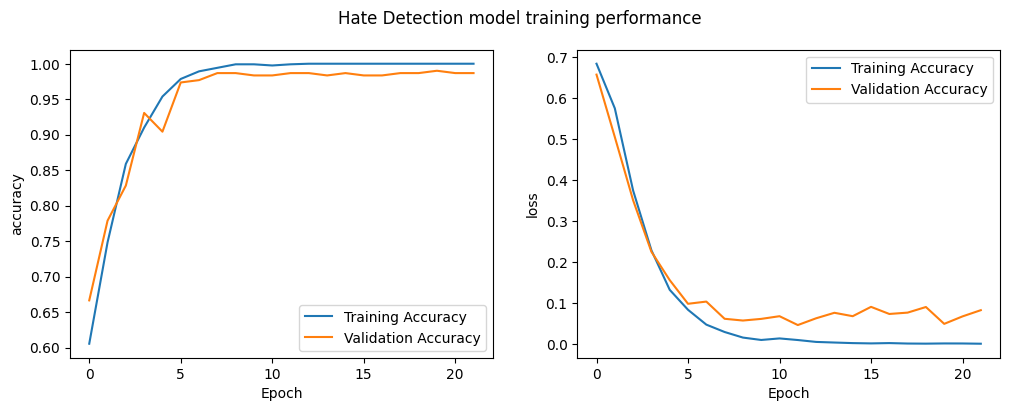

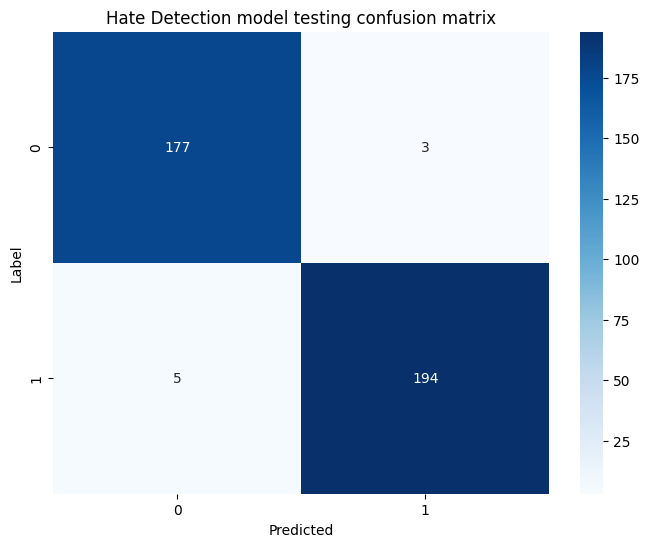

Hate Detection model testing:
Accuracy: 98.0%
Loss: 0.07
F1: 0.9788968269849914


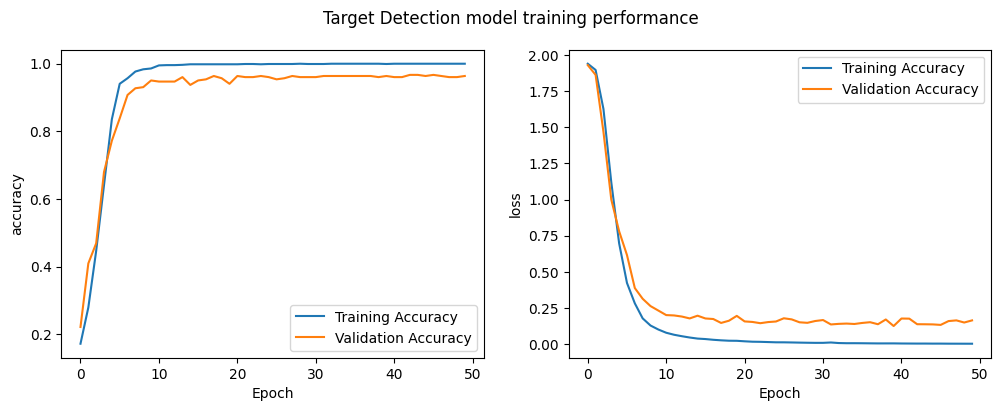

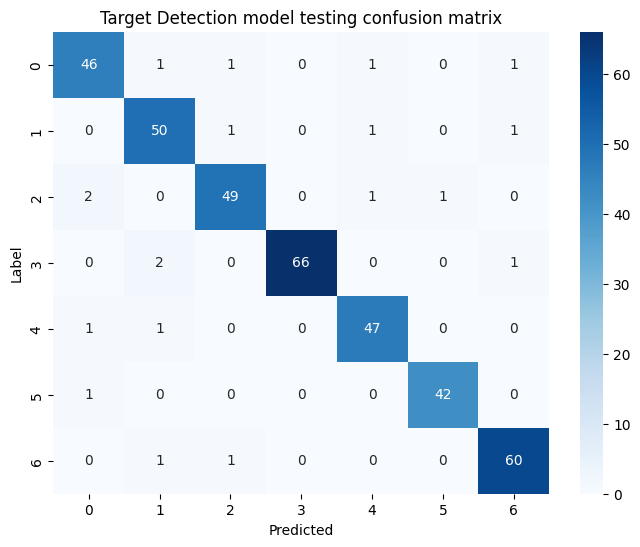

Target Detection model testing:
Accuracy: 95.0%
Loss: 0.28
F1: 0.9500070182919788


In [237]:
# Self explanatory code
for (model_name, model), labels in zip(models.items(), [test_labels, test_targets]):
    test_loss, test_accuracy = model['model'].evaluate(test_texts, labels, verbose=0)
    predictions = model['model'].predict(test_texts, verbose=0)
    
    if labels.shape[1] == 1: # For binary model
        # Translate based on if prediction probability is above/below 50%
        predicted_classes = (predictions >= 0.5).astype(int).flatten()
        actual_classes = labels.flatten()
    else: # For multi-class model
        # Translate using argmax to convert into number labels
        predicted_classes = np.argmax(predictions, axis=1)
        actual_classes = np.argmax(labels, axis=1)

    f1 = f1_score(actual_classes, predicted_classes, average='weighted')
    cm = confusion_matrix(actual_classes, predicted_classes)
    
    plt.figure(figsize=(12, 4))
    
    for subplot, metric in enumerate(['accuracy', 'loss'], 1):
        plt.subplot(1, 2, subplot)
        plt.plot(model['history'].history[metric], label='Training Accuracy')
        plt.plot(model['history'].history[f'val_{metric}'], label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()

    plt.suptitle(f'{model_name} model training performance')
    plt.show()

    # Plotting the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm,
        annot=True,
        fmt='d',
        cmap='Blues', 
        xticklabels=np.unique(actual_classes),
        yticklabels=np.unique(actual_classes)
    )
    
    plt.xlabel('Predicted')
    plt.ylabel('Label')
    plt.title(f'{model_name} model testing confusion matrix')
    plt.show()
    
    print(
        f'{model_name} model testing:\n'
        f'Accuracy: {round(test_accuracy, 2) * 100}%\n'
        f'Loss: {round(test_loss, 2)}\n'
        f'F1: {f1}'
    )